# Prevendo a inflação no Brasil: implementando modelos de médias móveis
---

# Carregando bibliotecas e importando os dados

In [2]:
import pandas as pd
import numpy as np
from bcb import sgs
import warnings
warnings.filterwarnings('ignore')

In [3]:
ipca = sgs.get(('varmen', 433), start = '2007-01-01', end = '2022-05-01')
# ipca.reset_index(inplace=True) # resetando o índice para o padrão e tranformando a data em uma coluna separada
print(ipca.tail())

            varmen
Date              
2022-01-01    0.54
2022-02-01    1.01
2022-03-01    1.62
2022-04-01    1.06
2022-05-01    0.47


In [4]:
print(ipca.head())

            varmen
Date              
2007-01-01    0.44
2007-02-01    0.44
2007-03-01    0.37
2007-04-01    0.25
2007-05-01    0.28


In [5]:
ipca_oos = sgs.get(('varmen', 433), start = '2022-06-01')
# ipca.reset_index(inplace=True) # resetando o índice para o padrão e tranformando a data em uma coluna separada
print(ipca_oos.tail())

            varmen
Date              
2022-05-01    0.47


# Análise exploratória: tendência e sazonalidade da variação mensal do IPCA
---

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

In [7]:
ipca_sd = seasonal_decompose(ipca.varmen, period = 12)
ipca_sd

Criando função para plotar a decomposição da série e visualizarmos os resultados em ipca_sd (= ipca seasonal decompose)

In [8]:
def sd_plot(y1, y2, y3, cor1, cor2, cor3, label1, label2, label3, title):
    plt.figure(figsize=(16, 10))
    plt.plot(y1, color=cor1, label=label1)
    plt.plot(y2, color=cor2, label=label2)
    plt.plot(y3, color=cor3, label=label3)
    plt.legend(fontsize=12)
    plt.title(title, fontsize = 24, loc = 'left')

Visualizando a decomposição na série completa

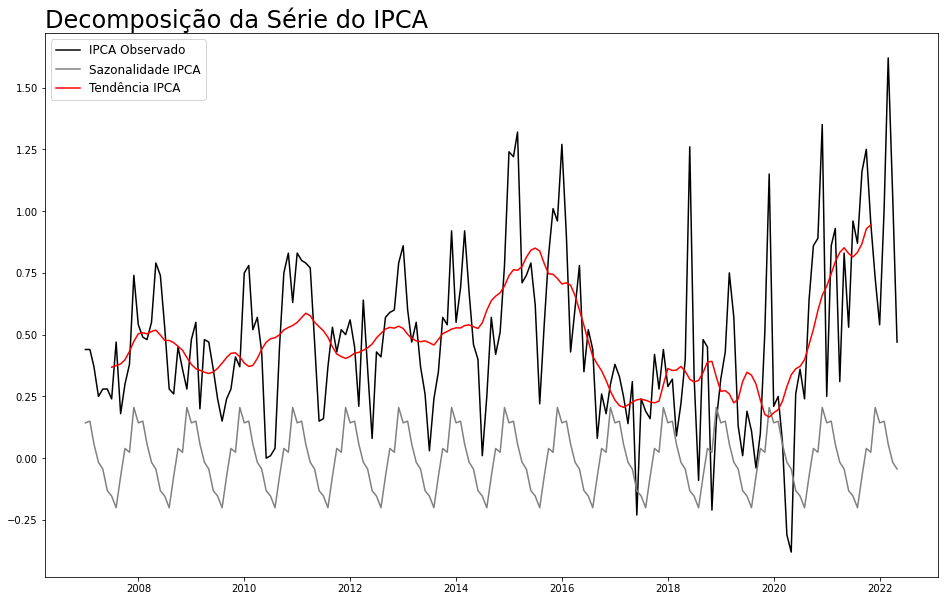

In [9]:
sd_plot(ipca_sd.observed, ipca_sd.seasonal, ipca_sd.trend,
        'black', 'grey', 'red',
        'IPCA Observado', 'Sazonalidade IPCA', 'Tendência IPCA',
        'Decomposição da Série do IPCA')

Visualizando a decomposição em apenas dois anos, 2007 e 2008

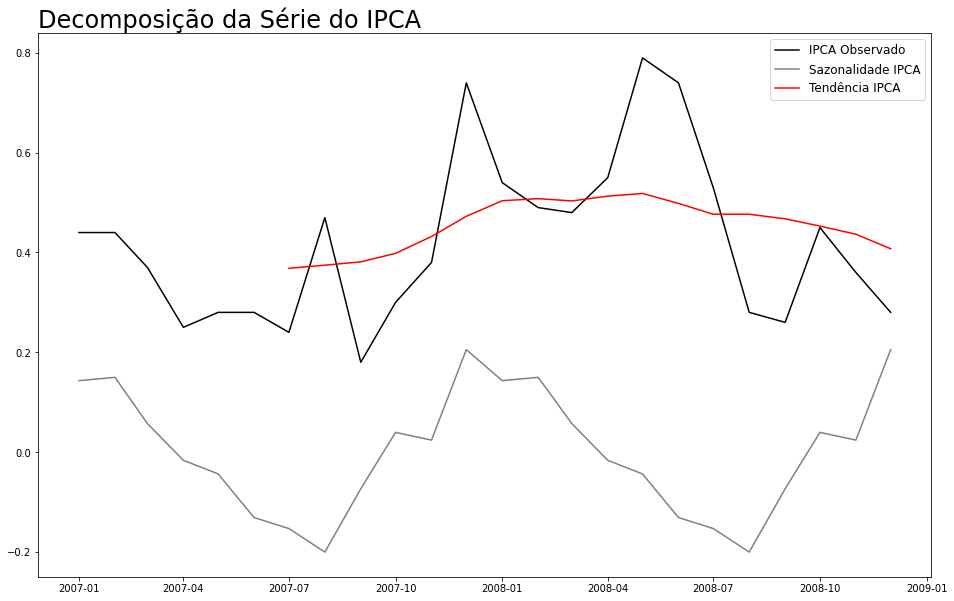

In [10]:
sd_plot(ipca_sd.observed[:24], ipca_sd.seasonal[:24], ipca_sd.trend[:24],
        'black', 'grey', 'red',
        'IPCA Observado', 'Sazonalidade IPCA', 'Tendência IPCA',
        'Decomposição da Série do IPCA')

# Estacionariedade e Autocorrelação

In [11]:
from statsmodels.tsa.stattools import adfuller

### Teste ADF

$H_0$: a série é estacionária e suas estatísticas variam no tempo 

$H_1$: a série é estacionária

In [12]:
ipca_adf = adfuller(ipca.varmen.dropna())
print('pvalor = {}'.format(round(ipca_adf[1], 4)))

pvalor = 0.0


Podemos rejeitar a hipótese nula e dizer que a série do IPCA para a variação mensal é estacionária.

### Visualizando a autocorrelação

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Criando função para plotar as autocorrelações entre o valor obervado, observado com primeira e com segunda diferenciação.

In [14]:
def autocorr_plots(y1, y2, y3, y4):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(411) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a primeira posição
    fig = plot_acf(y1, ax = ax1, title = 'Sem diferenciação')
    ax2 = fig.add_subplot(412) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a segunda posição
    fig = plot_acf(y2, ax=ax2, title = '1ª diferenciação')
    ax3 = fig.add_subplot(413) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a terceira posição
    fig = plot_acf(y3, ax = ax3, title = '2ª diferenciação')
    ax4 = fig.add_subplot(414) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a terceira posição
    fig = plot_pacf(y4, ax = ax4, title = 'Correlação parcial')

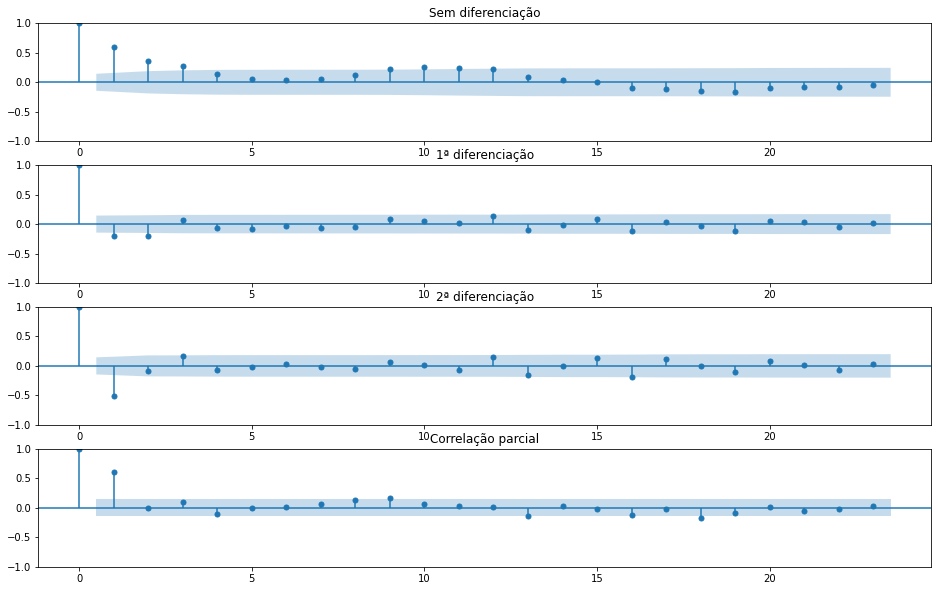

In [15]:
autocorr_plots(ipca.varmen, ipca.varmen.diff().dropna(), ipca.varmen.diff().diff().dropna(), ipca.varmen)

> Após o teste ADF e as análises gráficas, vamos considerar a variação mensal do IPCA como uma série estacionária. Com isso, podemos estimar os modelos.


# Seasonal Autoregressive Integrated Moving Average Models (SARIMA)

Com a presença de sazonalidade na série do IPCA, usaremos o ARIMA com a correção sazonal, conhecido como Seasonal ARIMA ou SARIMA.

> Mesmo sabendo que provavelmente, por se tratar de uma série estacionária, o SARIMA (1,0,0)(0,0,1) seria a melhor adequação, iremos testar diversas combinações de parâmetros para escolher o melhor modelo. 

In [16]:
import itertools

> Criando as combinações de parâmetros

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [18]:
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

Construindo o modelo

In [19]:
import statsmodels.api as sm

In [20]:
aic_list = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        sarima_ipca = sm.tsa.statespace.SARIMAX(ipca.varmen,
                                                order = param,
                                                seasonal_order = seasonal_param)
        results_sarima = sarima_ipca.fit()
        aic_list.append('ARIMA {}x{} - AIC: {}'.format(param, seasonal_param, results_sarima.aic))

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\l

In [21]:
aic_list

['ARIMA (0, 0, 0)x(0, 0, 0, 12) - AIC: 330.18620975841804',
 'ARIMA (0, 0, 0)x(0, 0, 1, 12) - AIC: 241.8625116381861',
 'ARIMA (0, 0, 0)x(0, 1, 0, 12) - AIC: 172.61356580485258',
 'ARIMA (0, 0, 0)x(0, 1, 1, 12) - AIC: 129.7601670621106',
 'ARIMA (0, 0, 0)x(1, 0, 0, 12) - AIC: 181.22263695687505',
 'ARIMA (0, 0, 0)x(1, 0, 1, 12) - AIC: 149.23881220105676',
 'ARIMA (0, 0, 0)x(1, 1, 0, 12) - AIC: 158.63303832471527',
 'ARIMA (0, 0, 0)x(1, 1, 1, 12) - AIC: 125.40886244054394',
 'ARIMA (0, 0, 1)x(0, 0, 0, 12) - AIC: 192.94428080085777',
 'ARIMA (0, 0, 1)x(0, 0, 1, 12) - AIC: 147.17681988046323',
 'ARIMA (0, 0, 1)x(0, 1, 0, 12) - AIC: 124.45071675875099',
 'ARIMA (0, 0, 1)x(0, 1, 1, 12) - AIC: 74.10195007994376',
 'ARIMA (0, 0, 1)x(1, 0, 0, 12) - AIC: 112.72693260649726',
 'ARIMA (0, 0, 1)x(1, 0, 1, 12) - AIC: 83.54185494274932',
 'ARIMA (0, 0, 1)x(1, 1, 0, 12) - AIC: 103.03790035209461',
 'ARIMA (0, 0, 1)x(1, 1, 1, 12) - AIC: 71.64116062218872',
 'ARIMA (0, 1, 0)x(0, 0, 0, 12) - AIC: 76.219

In [22]:
results_sarima.aic

65.72148143709799

Apesar de existirem modelos com menor AIC, sabemos por motivos teóricos que, como a série é estacionária, não precisaremos de diferenciação. Além disso, caso a série seja diferenciada, teremos intervalos de confiança extremamente amplos para os primeiros períodos da série.

Por isso, usaremoso seguinte modelo: ARIMA (1, 0, 0)x(1, 0, 0, 12).

In [23]:
sarima_ipca = sm.tsa.statespace.SARIMAX(ipca.varmen,
                                                order = (1, 0, 0),
                                                seasonal_order = (1, 0, 0, 12))
results_sarima = sarima_ipca.fit()
print(results_sarima.summary())

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             varmen   No. Observations:                  185
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -28.348
Date:                            Mon, 04 Jul 2022   AIC                             62.696
Time:                                    12:01:48   BIC                             72.357
Sample:                                01-01-2007   HQIC                            66.611
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8284      0.034     24.251      0.000       0.761       0.895
ar.S.L12       0.2177      0.063   

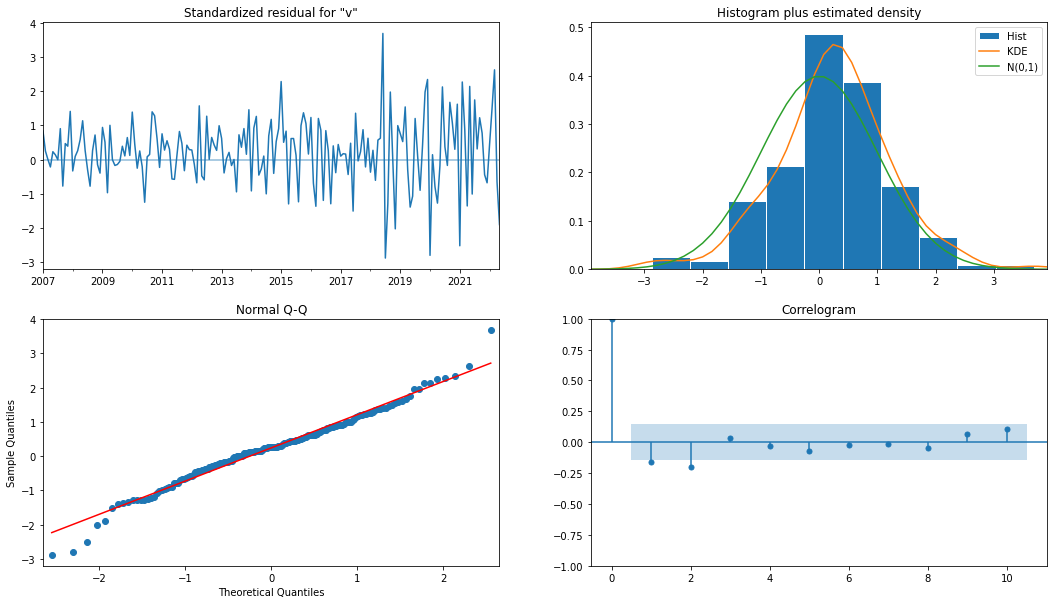

In [24]:
results_sarima.plot_diagnostics(figsize = (18,10))
plt.show()

## Estimando o Arima simples

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
arima_ipca = ARIMA(ipca.varmen,
                   order = (1, 0, 0))
results_arima = arima_ipca.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                 varmen   No. Observations:                  185
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -16.260
Date:                Mon, 04 Jul 2022   AIC                             38.519
Time:                        12:01:49   BIC                             48.180
Sample:                    01-01-2007   HQIC                            42.435
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4861      0.051      9.607      0.000       0.387       0.585
ar.L1          0.5945      0.051     11.734      0.000       0.495       0.694
sigma2         0.0696      0.006     11.315      0.0

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Fazendo as previsões
---

## Previsões dentro da amostra com intervalos de confiança

In [27]:
predict = results_sarima.get_prediction(start = pd.to_datetime('2007-01-01'), dynamic = False)
predict_ci = predict.conf_int()
predict_ci

,lower varmen,upper varmen
2007-01-01,-1.029267,1.029267
2007-02-01,-0.195384,0.931749
2007-03-01,-0.194606,0.932465
2007-04-01,-0.251625,0.875358
2007-05-01,-0.349813,0.777040
...,...,...
2022-01-01,-0.134443,0.965784
2022-02-01,0.039344,1.139572
2022-03-01,0.333906,1.434133
2022-04-01,0.691603,1.791831


In [28]:
predict_arima = results_arima.get_prediction(start = pd.to_datetime('2007-01-01'), dynamic = False)

In [29]:
predict.predicted_mean

2007-01-01    0.000000
2007-02-01    0.368183
2007-03-01    0.368930
2007-04-01    0.311866
2007-05-01    0.213614
                ...   
2022-01-01    0.415671
2022-02-01    0.589458
2022-03-01    0.884019
2022-04-01    1.241717
2022-05-01    1.002854
Freq: MS, Name: predicted_mean, Length: 185, dtype: float64

> Cores: https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

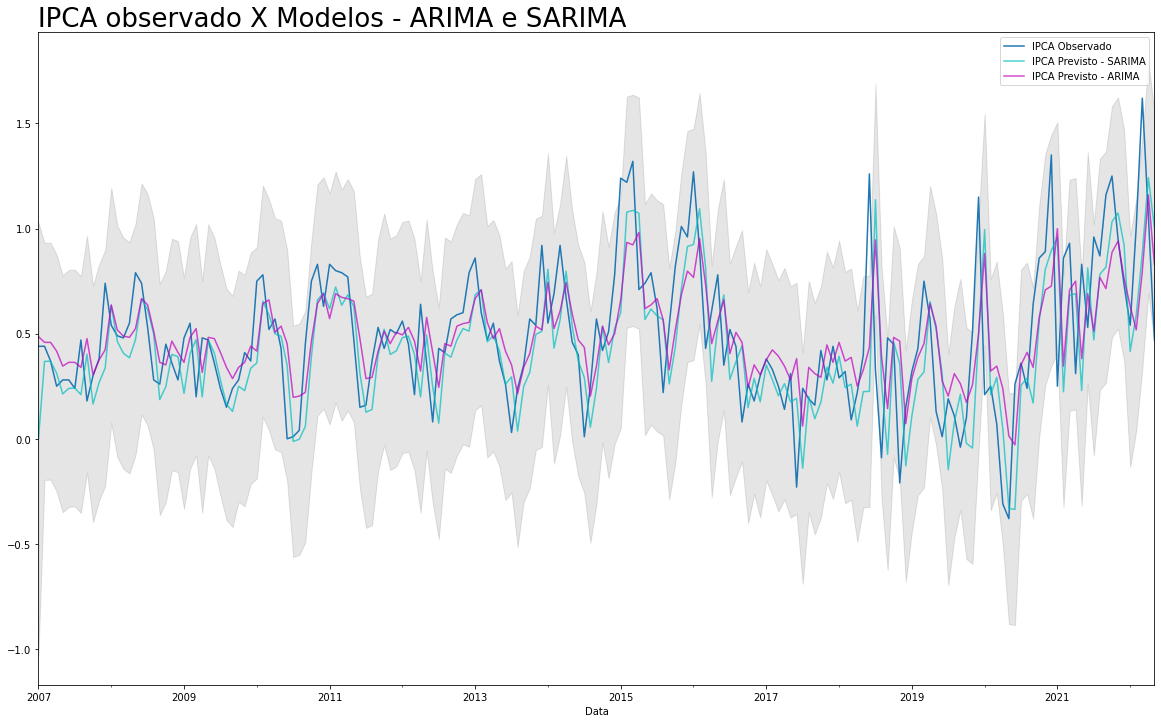

In [30]:
ax = ipca.varmen['2007':].plot(label = 'IPCA Observado')
predict.predicted_mean.plot(ax = ax, color = 'c', alpha = 0.7, figsize = (20,12), label = 'IPCA Previsto - SARIMA')
predict_arima.predicted_mean.plot(ax = ax, color = 'm', alpha = 0.7, figsize = (20,12), label = 'IPCA Previsto - ARIMA')
ax.fill_between(predict_ci.index, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='k', alpha=0.1)
ax.set_xlabel('Data')
ax.set_title('IPCA observado X Modelos - ARIMA e SARIMA', fontsize = 26, loc = 'left')
plt.legend()
plt.show()

## Previsões fora da amostra

In [31]:
ipca_oos.head()

,varmen
Date,
2022-05-01,0.47


In [32]:
sarima_prev_ipca = results_sarima.get_forecast(steps = 5)
sarima_prev_ci = sarima_prev_ipca.conf_int()
print(sarima_prev_ipca.predicted_mean, sarima_prev_ci, sep = '\n\n')

2022-06-01    0.355032
2022-07-01    0.407513
2022-08-01    0.353847
2022-09-01    0.388757
2022-10-01    0.384971
Freq: MS, Name: predicted_mean, dtype: float64

            lower varmen  upper varmen
2022-06-01     -0.195082      0.905146
2022-07-01     -0.306826      1.121853
2022-08-01     -0.454095      1.161789
2022-09-01     -0.477582      1.255097
2022-10-01     -0.519260      1.289202


In [33]:
arima_prev_ipca = results_arima.get_forecast(steps = 5)
arima_prev_ci = arima_prev_ipca.conf_int()
print(arima_prev_ipca.predicted_mean, arima_prev_ci, sep = '\n\n')

2022-06-01    0.476527
2022-07-01    0.480407
2022-08-01    0.482714
2022-09-01    0.484086
2022-10-01    0.484901
Freq: MS, Name: predicted_mean, dtype: float64

            lower varmen  upper varmen
2022-06-01     -0.040676      0.993730
2022-07-01     -0.121294      1.082109
2022-08-01     -0.146143      1.111571
2022-09-01     -0.154093      1.122265
2022-10-01     -0.156540      1.126342


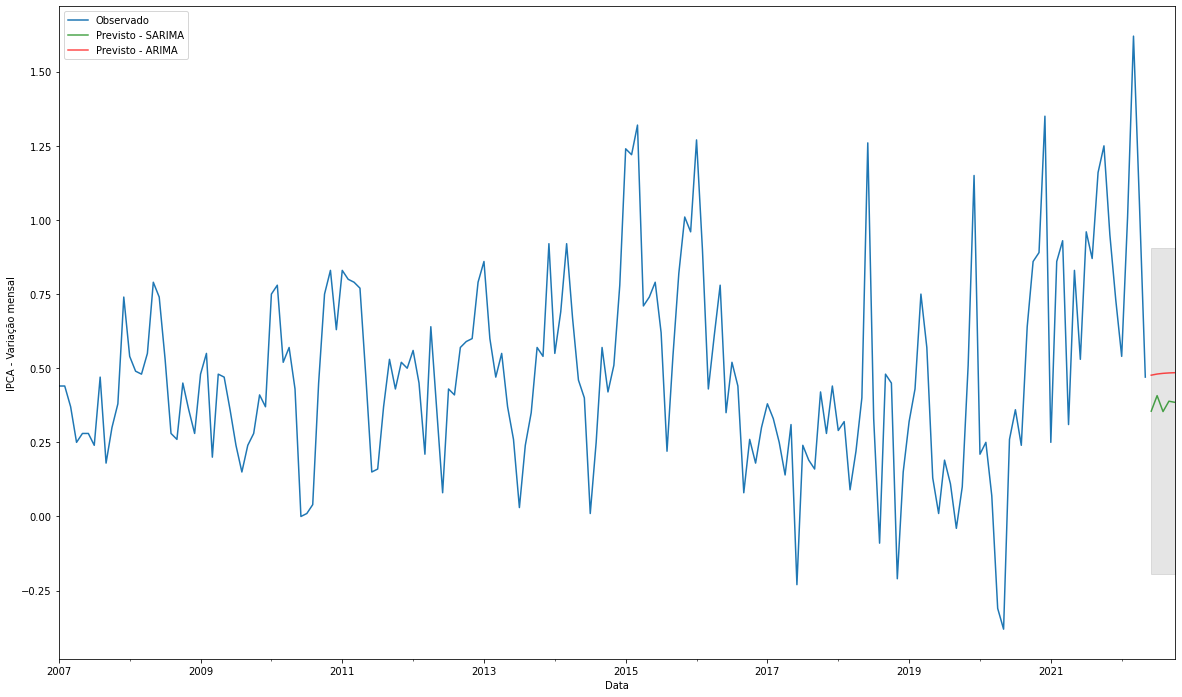

In [34]:
ax = ipca.varmen.plot(label = 'Observado')
sarima_prev_ipca.predicted_mean.plot(ax = ax, color = 'g', alpha = 0.7, figsize = (20, 12), label = 'Previsto - SARIMA')
arima_prev_ipca.predicted_mean.plot(ax = ax, color = 'r', alpha = 0.7, figsize = (20, 12), label = 'Previsto - ARIMA')
ax.fill_between(sarima_prev_ci.index, sarima_prev_ci['lower varmen'][0], sarima_prev_ci['upper varmen'][0], color = 'k', alpha = 0.1)
ax.set_xlabel('Data')
ax.set_ylabel('IPCA - Variação mensal')
plt.legend()
plt.show()

## Verificando as previsões com valores reais

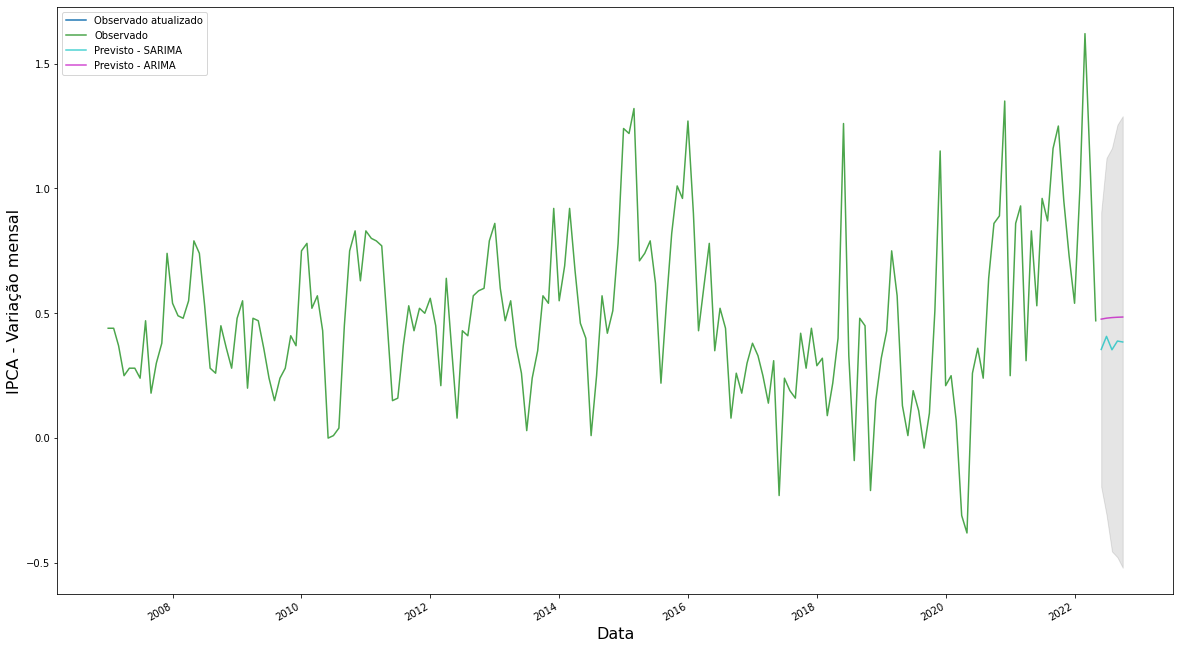

In [35]:
plt.figure(figsize = (20,12))
fig = plt.plot(ipca_oos.varmen, label = 'Observado atualizado')
ax = ipca.varmen.plot(label = 'Observado', color = 'g', alpha = 0.7)
sarima_prev_ipca.predicted_mean.plot(ax = ax, color = 'c', alpha = 0.7, figsize = (20, 12), label = 'Previsto - SARIMA')
arima_prev_ipca.predicted_mean.plot(ax = ax, color = 'm', alpha = 0.7, figsize = (20, 12), label = 'Previsto - ARIMA')
ax.fill_between(sarima_prev_ci.index, sarima_prev_ci.iloc[:,0], sarima_prev_ci.iloc[:,1], color = 'k', alpha = 0.1)
ax.set_xlabel('Data', fontsize = 16)
ax.set_ylabel('IPCA - Variação mensal', fontsize = 16)
plt.legend()
plt.show()